In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import plotly
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

- - -
# Einleitung
## Letzter Termin (reminder)
Ziele für die den Termin:
 + Neue Sentiment Modelle finden und anschauen
 + Auswertung der Sentiments auf die jeweiligen Firmen
 + Optional: Auswertung der Tweets (leider zeitlich nicht geschafft).

Probleme:
 + RoBERTa, XLM-RoBERTa und BERT scheinen sehr ähnlich zu sein
 + Bei einigen Firmen kam es zu Problemen bei der Nutzung von RoBERTa (wird immer noch gesucht)
 + Output Qualität der neuen Sentiments scheint dürftig zu sein

Vorschläge / Ziele:
 + Michael: statistische Analyse der Outputs der Modelle zueinander und der Aktienkurse, um deren Wirkung zu evaluieren
 + Merih: Aufbereitung von Rohstoff preisen als alternative Features
 + Alexander: Säuberung und Skalierung der Daten von den BERT Modellen. Analyse der Wirkung von BERT in Bezug auf VADER
- - -

## Neuer Termin

Ziele für den Termin:
+ Auswertung von den BERT Modellem mit skalierten Outputs
+ Auswertung vom Effekt der Rohstoffpreisen auf den Aktienpreis
+ Erste Analyse (lineare Regression)


- - -
# Properties
- - -

In [2]:
path_to_sentiments = Path("./data/debug_multiprocess_eu_new/sentiments")
company_label = "RWE.DE"
file_name = f"PREPARED-PER-DAY-SENTIMENT-{company_label}.csv"
sep = ","

sentiment_labels = ["vader", "finbert", "roberta", "xlm-roberta", "bert"]
# VADER and FinBERT kennen wir schon - hier nur einmal auf die drei neuen schauen
#sentiment_labels = ["roberta", "xlm-roberta", "bert"]

df_company_sentiments = pd.read_csv(path_to_sentiments.joinpath(file_name), sep=sep)

# Functions and plots

In [3]:
df_company_sentiments.head()

created_at  si_vader  sum_vader  mean_vader  si_finbert  sum_finbert  \
0  2017-01-01  0.200489     0.5719      0.5719   -0.693147    -0.016961   
1  2017-01-02  0.218182     0.4844      0.2422    0.000000    -0.521466   
2  2017-01-05  0.255479     0.6904      0.3452    1.098612     1.174990   
3  2017-01-10  0.235862     0.4404      0.4404    0.693147     0.300190   
4  2017-01-24  0.272315     0.6249      0.6249    0.693147     0.128908   

   mean_finbert  si_roberta  sum_roberta  mean_roberta  si_xlm-roberta  \
0     -0.016961    0.693147     0.149522      0.149522        0.693147   
1     -0.260733    0.000000     0.000000      0.000000        0.000000   
2      0.587495    0.693147     0.034838      0.017419        0.000000   
3      0.300190    0.693147     0.034838      0.034838        0.000000   
4      0.128908    0.693147     0.160557      0.160557        0.693147   

   sum_xlm-roberta  mean_xlm-roberta   si_bert  sum_bert  mean_bert  
0         0.037018          0.037018  0.693147  0.017115   0.017115  
1         0.000000          0.000000  0.000000  0.011796   0.005898  
2         0.000000          0.000000  1.098612  0.093372   0.046686  
3         0.000000          0.000000  0.693147  0.071687   0.071687  
4         0.075798          0.075798  0.693147  0.128100   0.128100

In [4]:
# Delete later, this is to scale berts to have a better representation
mask_new_berts = ["sum_roberta", "mean_roberta", "sum_xlm-roberta", "mean_xlm-roberta", "sum_bert", "mean_bert"]
#df_company_sentiments.loc[:, mask_new_berts] = df_company_sentiments.loc[:, mask_new_berts].apply(lambda x: x*10)

In [5]:
def plot_sentiments_type(sentiment_type: str, sentiment_labels: list[str], df_data: pd.DataFrame):
    fig = make_subplots(rows=1, cols=1)
    traces = list()
    for label in sentiment_labels:
        # fig = px.line(df_data, x="created_at", y=sentiment_type + "_" + label)
        trace = go.Scatter(x=df_data.loc[:, "created_at"], 
                           y=df_data.loc[:, sentiment_type + "_" + label],
                           name=label)
        traces.append(trace)
    for trace in traces:
        fig.append_trace(trace, 1, 1)
    return fig

- - -
## Plots für die jeweiligen Sentiments

Beispiel Plots der Sentiments vom gesamten Zeitraum für Firma X. Bloomberg Daten sind nicht einbezogen in den Graphen (Bloomberg besitzt nur SI).
- - -

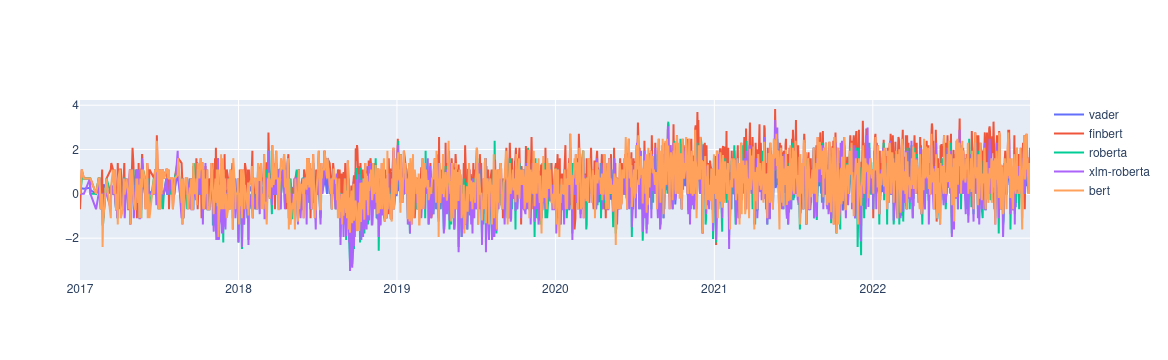

In [6]:
fig_si = plot_sentiments_type("si", sentiment_labels, df_company_sentiments)
fig_si

In [7]:
plotly.io.write_image(fig_si, f"./images/{company_label}_SI.png")

- - -
Nach der Änderungen - deutlich mehr Schwankungen zwischen Positiven und Negativen Sentiments.  
Alle BERT Modelle zeigen ein ähnliches Muster, aber mit Abweichungen. Interessant wäre hier die Wirkung der unterschiedlichen Varianten auf ihre Wirkung bei der Vorhersage.
- - -

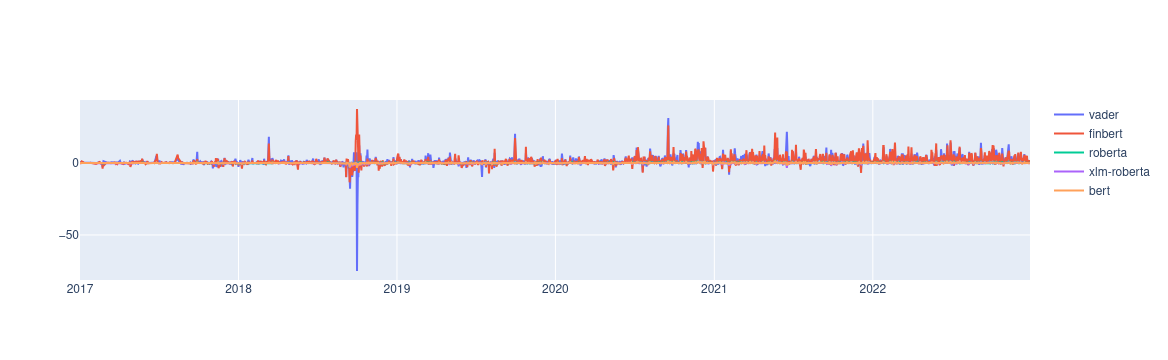

In [8]:
fig_sum = plot_sentiments_type("sum", sentiment_labels, df_company_sentiments)
fig_sum

Hier interessanter - die neuen BERT Modelle haben ähnliche Prägungen in der Summe zu fast den gleichen Zeiten mit unterschiedlich großen Wirkungen. RoBERTa, XLM-RoBERTa und BERT sind sehr nah zueinander.

In [9]:
# Plot speichern
plotly.io.write_image(fig_sum, f"./images/{company_label}_SUM.png")

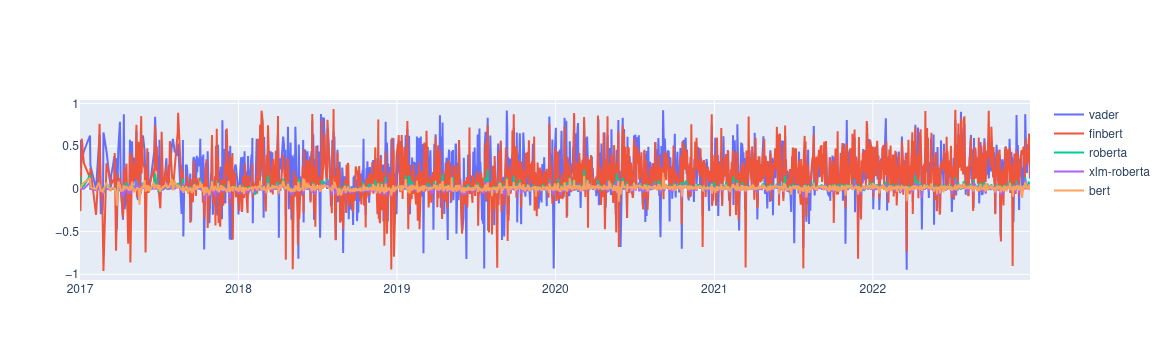

In [10]:
fig_mean = plot_sentiments_type("mean", sentiment_labels, df_company_sentiments)
fig_mean

In [11]:
plotly.io.write_image(fig_mean, f"./images/{company_label}_MEAN.png")

- - -
# Regressionsanalyse
 + Einfache lineare Regression
 + Matrix für R, $\sigma$ und P Werte
 + Korrelation nach Pearson

TODO:
 + Split into multidim pd -> sum: vader, finbert, bert etc. mean: ... and so on for better visualization

In [12]:
from scipy.stats import linregress
from sklearn.linear_model import LogisticRegression

In [13]:
def regression_matrix_styling(value):
    if value < -0.5:
        return "background:red;"
    elif value < 0:
        return "background:lightcoral;"
    if value > 0.75:
        return "background:darkgreen;color:white;"
    elif value > 0.5:
        return "background:forestgreen;"
    elif value > 0:
        return "background:lightgreen;"

def formate_df_styling(styler):
    styler.background_gradient(axis=None, cmap="coolwarm")
    styler.set_properties(**{'text-align': 'left'})
    styler.set_table_styles([{'selector': 'th.col_heading', 'props': 'text-align: center;'},
                             {'selector': 'th.row_heading', 'props': 'text-align: left;'}])
    border_color = "black"
    line_width = 5

    styler.set_table_styles({
        ("si", "vader"): [{"selector": "th", "props":f"border-top: {line_width}px solid {border_color}"},
                          {"selector": "td", "props":f"border-top: {line_width}px solid {border_color}"}],
        ("sum", "vader"): [{"selector": "th", "props":f"border-top: {line_width}px solid {border_color}"},
                          {"selector": "td", "props":f"border-top: {line_width}px solid {border_color}"}],
        ("mean", "vader"): [{"selector": "th", "props":f"border-top: {line_width}px solid {border_color}"},
                          {"selector": "td", "props":f"border-top: {line_width}px solid {border_color}"}],
    }, overwrite=False, axis=1)
    styler.set_table_styles({
    ('si', 'vader'): [{'selector': 'th', 'props': f'border-left: {line_width}px solid {border_color}'},
                      {'selector': 'td', 'props': f'border-left: {line_width}px solid {border_color}'}],
    ("sum", "vader"): [{'selector': 'th', 'props': f'border-left: {line_width}px solid {border_color}'},
                      {'selector': 'td', 'props': f'border-left: {line_width}px solid {border_color} '}],
    ("mean", "vader"): [{'selector': 'th', 'props': f'border-left: {line_width}px solid {border_color};'},
                       {'selector': 'td', 'props': f'border-left: {line_width}px solid {border_color}'}],
    }, overwrite=False, axis=0)
    return styler

def generate_linear_regressions_matrix(df_data: pd.DataFrame, 
                                       labels: list[str], 
                                       sentiment_types: list[str]):
    columns = []
    for label in labels:
        for sent_type in sentiment_types:
            columns.append(sent_type + "_" + label)
    result_r = pd.DataFrame(index=columns, columns=columns)
    result_std = pd.DataFrame(index=columns, columns=columns)
    result_p = pd.DataFrame(index=columns, columns=columns)
    for first_sentiment in columns:
        for second_sentiment in columns:
            res = linregress(df_data.loc[:, first_sentiment], df_data.loc[:, second_sentiment])
            result_r.loc[first_sentiment, second_sentiment] = res.rvalue
            result_std.loc[first_sentiment, second_sentiment] = res.stderr
            result_p.loc[first_sentiment, second_sentiment] = res.pvalue
    return result_r, result_std, result_p


def convert_matrix_to_multiindex(df_data: pd.DataFrame,
                                 new_index: list[tuple[str, str]]) -> pd.DataFrame:
    df_data.set_index(new_index, inplace=True)
    df_data = df_data.transpose().set_index(new_index)
    df_data = df_data.apply(pd.to_numeric)
    return df_data

Nützliche Masken zur Visualisierung

In [14]:
sentiment_types = ["si", "sum", "mean"]
new_model_mask = [s_type + "_" + s_label for s_label in sentiment_labels if s_label in ["bert", "roberta", "xlm-roberta"] for s_type in sentiment_types] 
tuples = [(sent_type, sent_label) for sent_type in sentiment_types for sent_label in sentiment_labels]

df_r_matrix, df_std_matrix, df_p_matrix = generate_linear_regressions_matrix(df_company_sentiments, sentiment_labels, sentiment_types)
new_index = pd.MultiIndex.from_tuples(tuples, names=["type", "sentiment"])

df_r_matrix.set_index(new_index, inplace=True)

df_r_matrix = df_r_matrix.transpose().set_index(new_index)
df_r_matrix = df_r_matrix.apply(pd.to_numeric)

df_std_matrix = convert_matrix_to_multiindex(df_std_matrix, new_index)
df_p_matrix = convert_matrix_to_multiindex(df_p_matrix, new_index)

## Lineare Regressionsmatrix - R-Werte zwischen Sentiments

R-Wert Matrix zwischen allen Sentiment typen die wir haben. Die wichtigsten Funde sind:

SI x SI:
+ Vader hat mit den BERT Modellen 60%
+ BERT Modelle untereinander geringe R
+ BERT und RoBERTa scheinen hier sehr unterschiedliche Werte zu erzeugen

SUM x SUM:
+ FinBERT und BERT weisen sehr hohen R Wert auf
+ Gleiche für FinBERT und RoBERTa

MEAN x MEAN:
+ VADER und XLM-RoBERTa weisen hohen R Wert auf
+ FinBERT und BERT zeigen wieder ein hohen R Wert

Unterschiedliche Sentiments (Sum/Mean/Si):
+ Der Mean von VADER und die Summe von RoBERTa zeigen hohen R Wert auf
+ BERT Summe zeigt hohe R Werte mit Mean der anderen BERT Modelle (außer BERT selbst)

In [15]:
df_r_matrix.style.pipe(formate_df_styling)

In [16]:
df_r_matrix.loc["si", "si"].style.pipe(formate_df_styling)

### Gruppierte Ansicht für besseren Überblick

### R²-Matrix zwischen Sentiments

In [17]:
df_r2_matrix = df_r_matrix.apply(lambda x: x**2 * 100)
df_r2_matrix.style.pipe(formate_df_styling)

In [18]:
df_r2_matrix.loc["mean", "mean"].style.pipe(formate_df_styling)

In [19]:
df_r2_matrix.loc["mean", "sum"].style.pipe(formate_df_styling)

Stderr der jeweiligen Regression - Nichts interessantes gefunden

In [20]:
df_std_matrix

type                    si                                            \
sentiment            vader   finbert   roberta xlm-roberta      bert   
type sentiment                                                         
si   vader        0.000000  0.002024  0.028259    0.008209  0.002516   
     finbert      0.134598  0.000000  0.275003    0.077899  0.023386   
     roberta      0.011337  0.001659  0.000000    0.005980  0.001928   
     xlm-roberta  0.040981  0.005849  0.074416    0.000000  0.005416   
     bert         0.141395  0.019766  0.270115    0.060961  0.000000   
sum  vader        0.012737  0.001683  0.018912    0.004798  0.001634   
     finbert      0.038202  0.005621  0.068249    0.017479  0.005833   
     roberta      0.011857  0.001551  0.023462    0.006054  0.001620   
     xlm-roberta  0.001640  0.000216  0.002235    0.000744  0.000236   
     bert         0.039800  0.005815  0.071172    0.017643  0.006024   
mean vader        0.014281  0.001708  0.025124    0.006801  0.002040   
     finbert      0.001349  0.000185  0.001819    0.000590  0.000199   
     roberta      0.042631  0.005814  0.072797    0.018644  0.006299   
     xlm-roberta  0.011656  0.001340  0.021818    0.005756  0.001746   
     bert         0.001417  0.000186  0.002049    0.000629  0.000202   

type                   sum                                            \
sentiment            vader   finbert   roberta xlm-roberta      bert   
type sentiment                                                         
si   vader        0.034245  0.007630  0.025120    0.272805  0.007298   
     finbert      0.300820  0.074655  0.218533    2.391824  0.070895   
     roberta      0.020399  0.005469  0.019941    0.149194  0.005236   
     xlm-roberta  0.064401  0.017430  0.064029    0.617960  0.016152   
     bert         0.246902  0.065474  0.192878    2.202035  0.062076   
sum  vader        0.000000  0.005174  0.018948    0.153891  0.004746   
     finbert      0.069642  0.000000  0.049347    0.496948  0.011126   
     roberta      0.024046  0.004652  0.000000    0.176624  0.004959   
     xlm-roberta  0.002487  0.000597  0.002249    0.000000  0.000618   
     bert         0.069593  0.012119  0.057297    0.561100  0.000000   
mean vader        0.025846  0.005542  0.013863    0.202025  0.005186   
     finbert      0.001917  0.000496  0.001980    0.011237  0.000430   
     roberta      0.072481  0.017151  0.064824    0.592891  0.015793   
     xlm-roberta  0.022447  0.005009  0.013236    0.177063  0.004821   
     bert         0.002193  0.000573  0.002096    0.015091  0.000552   

type                  mean                                            
sentiment            vader   finbert   roberta xlm-roberta      bert  
type sentiment                                                        
si   vader        0.026413  0.296759  0.008861    0.029530  0.322127  
     finbert      0.210056  2.699807  0.080350    0.225740  2.811158  
     roberta      0.018641  0.160583  0.006070    0.022174  0.186788  
     xlm-roberta  0.062802  0.648164  0.019348    0.072801  0.714030  
     bert         0.212066  2.455298  0.073579    0.248564  2.584842  
sum  vader        0.017779  0.156874  0.005603    0.021152  0.185341  
     finbert      0.051318  0.545863  0.017848    0.063538  0.651809  
     roberta      0.012102  0.205635  0.006360    0.015828  0.224851  
     xlm-roberta  0.002246  0.014860  0.000741    0.002696  0.020614  
     bert         0.052310  0.516144  0.017902    0.066604  0.683714  
mean vader        0.000000  0.219517  0.006764    0.014879  0.240880  
     finbert      0.001845  0.000000  0.000589    0.002271  0.016969  
     roberta      0.060189  0.623265  0.000000    0.062798  0.579345  
     xlm-roberta  0.010862  0.197267  0.005152    0.000000  0.191802  
     bert         0.001960  0.016427  0.000530    0.002138  0.000000

In [21]:
df_p_matrix

type                         si                                               \
sentiment                 vader        finbert        roberta    xlm-roberta   
type sentiment                                                                 
si   vader         0.000000e+00  5.799168e-281  9.780887e-218  1.135004e-198   
     finbert      5.799168e-281   0.000000e+00   1.557716e-79   4.167165e-80   
     roberta      9.780887e-218   1.557716e-79   0.000000e+00   2.388796e-89   
     xlm-roberta  1.135004e-198   4.167165e-80   2.388796e-89   0.000000e+00   
     bert         8.154827e-177   1.804557e-74   1.101779e-27  5.414012e-206   
sum  vader         3.560157e-97   6.856032e-39  3.807828e-145  7.427014e-232   
     finbert      1.299948e-254  2.973549e-112  4.403730e-158  2.279147e-237   
     roberta      3.350819e-246  1.247869e-195   9.402232e-70  2.566366e-143   
     xlm-roberta   2.539010e-87   1.678386e-30  4.558663e-202   1.334712e-76   
     bert         5.617011e-256  3.009251e-119  1.061211e-158  1.897771e-263   
mean vader        6.284324e-154  1.777518e-173   2.372826e-69  2.356043e-105   
     finbert      9.008741e-131   4.096382e-45  9.489367e-254  1.528772e-148   
     roberta      2.292952e-153   2.433911e-70   4.513823e-92  2.166216e-171   
     xlm-roberta  1.021610e-189  4.006675e-240   1.235073e-56  7.464079e-113   
     bert          2.603263e-79   4.199887e-26  2.466237e-148   1.480102e-85   

type                                       sum                                \
sentiment                  bert          vader        finbert        roberta   
type sentiment                                                                 
si   vader        8.154827e-177   3.560157e-97  1.299948e-254  3.350819e-246   
     finbert       1.804557e-74   6.856032e-39  2.973549e-112  1.247869e-195   
     roberta       1.101779e-27  3.807828e-145  4.403730e-158   9.402232e-70   
     xlm-roberta  5.414012e-206  7.427014e-232  2.279147e-237  2.566366e-143   
     bert          0.000000e+00  1.168700e-127  4.303746e-149  1.722858e-227   
sum  vader        1.168700e-127   0.000000e+00  7.486241e-172   4.033917e-80   
     finbert      4.303746e-149  7.486241e-172   0.000000e+00   0.000000e+00   
     roberta      1.722858e-227   4.033917e-80   0.000000e+00   0.000000e+00   
     xlm-roberta   2.161286e-29  2.723109e-148  5.215050e-248  1.001447e-133   
     bert         2.390858e-157  8.869906e-206   0.000000e+00  1.433078e-264   
mean vader        2.554939e-100   9.093141e-77  3.145745e-264   0.000000e+00   
     finbert       1.292468e-53  1.910969e-242  8.096665e-284  4.420007e-124   
     roberta       1.978062e-73  4.638587e-125  1.687835e-235  3.315615e-119   
     xlm-roberta   3.575700e-99   5.582610e-64  2.784885e-220   0.000000e+00   
     bert          5.552347e-26  7.690163e-125  6.174658e-158   6.896268e-67   

type                                                     mean                 \
sentiment           xlm-roberta           bert          vader        finbert   
type sentiment                                                                 
si   vader         2.539010e-87  5.617011e-256  6.284324e-154  9.008741e-131   
     finbert       1.678386e-30  3.009251e-119  1.777518e-173   4.096382e-45   
     roberta      4.558663e-202  1.061211e-158   2.372826e-69  9.489367e-254   
     xlm-roberta   1.334712e-76  1.897771e-263  2.356043e-105  1.528772e-148   
     bert          2.161286e-29  2.390858e-157  2.554939e-100   1.292468e-53   
sum  vader        2.723109e-148  8.869906e-206   9.093141e-77  1.910969e-242   
     finbert      5.215050e-248   0.000000e+00  3.145745e-264  8.096665e-284   
     roberta      1.001447e-133  1.433078e-264   0.000000e+00  4.420007e-124   
     xlm-roberta   0.000000e+00  1.480536e-186   8.938900e-82   0.000000e+00   
     bert         1.480536e-186   0.000000e+00  1.215828e-282   0.000000e+00   
mean vader         8.938900e-82  1.215828e-282   0.000000e+00  4.130868e-126  

pearson’ correlation used by pandas

In [22]:
df_for_corr = df_company_sentiments.loc[:, df_company_sentiments.columns[1:]].corr()
df_for_corr = convert_matrix_to_multiindex(df_for_corr, new_index)

## Sentiments mit starker Korrelation

+ SI Vader + SI FinBERT
+ Mean Vader + Mean XLM-RoBERTa
+ Mean XLM-RoBERTa + Sum FinBERT
+ Sum FinBERT + Sum BERT
+ Mean VADER + Sum RoBERTa
+ Mean XLM-RoBERta + Sum RoBERTa

In [23]:
df_for_corr.style.pipe(formate_df_styling)

## Vergleich mit Rohstoffpreisen

In [24]:
csv_sep = ";"
path_to_comm = f"./data/Comm-Prices"
path_to_company = f"./data/raw_energy_eu/stock/STOCK-Y-1d-{company_label}.csv"

In [25]:
def load_comm_from_csv(path_to_dir: str, comm_file_label: str, sep="\t") -> dict[str:pd.DataFrame]:
    dataframes = dict()
    for file_path in Path(path_to_comm).glob(comm_file_label + "*.csv"):
        comm_name = file_path.stem.split(comm_file_label)[-1]
        dataframes[comm_name] = preprocess_comm_df(pd.read_csv(file_path, sep=sep))
    return dataframes

def preprocess_comm_df(df_data: pd.DataFrame) -> pd.DataFrame:
    df_data = df_data.loc[: "Last Price"].dropna()
    df_data.loc[:, "Last Price"] = df_data.loc[:, "Last Price"].apply(lambda x: float(str(x).replace(",", ".")))
    return df_data

def plot_comm_prices(dict_dfs: dict[str:pd.DataFrame], 
                     x_label: str="Date", 
                     y_label: str="Last Price"):
    fig = make_subplots(rows=1, cols=1)
    traces = list()
    for key in dict_dfs.keys():
        trace = go.Scatter(x=dict_dfs[key].loc[:, x_label],
                           y=dict_dfs[key].loc[:, y_label],
                           name=key)
        traces.append(trace)
    for trace in traces:
        fig.append_trace(trace, 1, 1)
    #fig.update_layout(yaxis={'categoryorder':'array', "categoryarray": dict_dfs[key].loc[:, "Last Price"].sort_values()})
    return fig

dict_frames = load_comm_from_csv(path_to_comm, "GAS_")

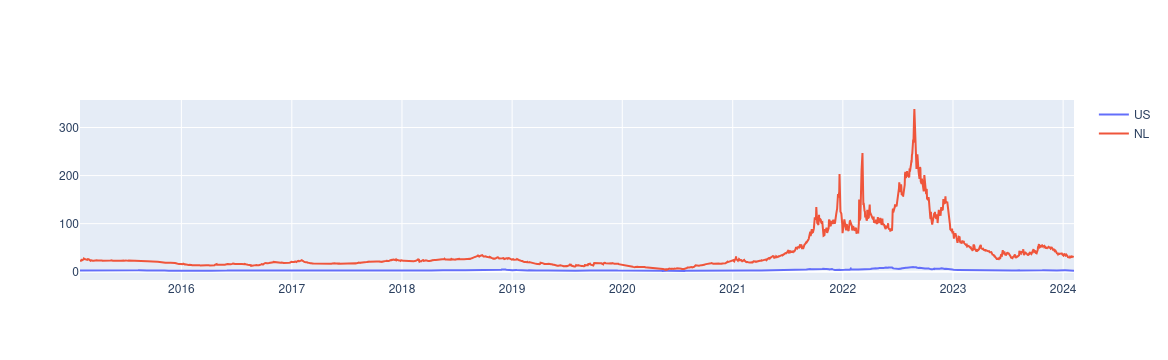

In [26]:
plot_comm_prices(dict_frames)

In [27]:
comm = "GAS_"
# Possible: coal: Africa, rotterdam, US
#           gas: NL, US
#           oil: BERNT, US_WIT
target_comm_key = "NL"

comm_label = "Last Price"

In [28]:
df_company = pd.read_csv(Path(path_to_company).resolve(), sep=csv_sep, index_col=0)
df_company = df_company.set_index(pd.to_datetime(df_company.index, utc=True).date)

In [29]:
def lin_reg_matrix_one_to_many(df_data: pd.DataFrame,
                               x_label: str,
                               y_labels: list[str]) -> pd.DataFrame:
    df_res = pd.DataFrame(index=y_labels, columns=["rvalue", "r2value", "slope", "pvalue", "stderr"])
    for y_label in y_labels:
        res = linregress(df_data.loc[:, x_label].astype(float), 
                         df_data.loc[:, y_label].astype(float))
        df_res.loc[y_label, :] = [res.rvalue, res.rvalue**2, res.slope, res.pvalue, res.stderr]
    return df_res

In [30]:
dict_frames = load_comm_from_csv(path_to_comm, comm)

In [31]:
df_sentiments_to_merge = df_company_sentiments.rename(columns={"created_at": "Date"}).set_index("Date")
df_sentiments_to_merge.index = pd.to_datetime(df_sentiments_to_merge.index)
df_merged_company = df_company.join(df_sentiments_to_merge)

In [32]:
df_merged_company.fillna(0, inplace=True)

In [33]:
df_target_comm = dict_frames[target_comm_key]
df_target_comm.set_index("Date", inplace=True)
df_target_comm.index = pd.to_datetime(df_target_comm.index)
df_comm_company = df_target_comm.join(df_merged_company)
#df_comm_company.fillna(0, inplace=True)
df_comm_company = df_comm_company.ffill()
df_comm_company = df_comm_company.reset_index()

In [34]:
mask_start = df_comm_company["Date"] >= "2018-01-01"
mask_ending = df_comm_company["Date"] < "2021-01-01"

df_comm_range = df_comm_company.loc[mask_start & mask_ending, :]

In [35]:
df_comm_range.head()

Date  Last Price  Open Interest  SMAVG (15)       Open       High  \
800 2020-12-31      23.378       132311.0     87426.0  33.994781  34.061456   
801 2020-12-30      23.350        61807.0     85503.0  33.994781  34.061456   
802 2020-12-29      22.983        68025.0     88471.0  33.213728  33.394706   
803 2020-12-28      23.377        68478.0     91036.0  33.432805  33.737606   
804 2020-12-24      21.502        69500.0     93715.0  33.432805  33.737606   

           Low      Close     Volume  Dividends  ...  mean_finbert si_roberta  \
800  33.366130  33.528057  1981977.0        0.0  ...      0.135370   0.287682   
801  33.366130  33.528057  1981977.0        0.0  ...      0.135370   0.287682   
802  32.851780  32.927979  1036749.0        0.0  ...     -0.139916  -2.036882   
803  33.204207  33.289932  1677246.0        0.0  ...      0.170161   0.000000   
804  33.204207  33.289932  1677246.0        0.0  ...      0.170161   0.000000   

     sum_roberta  mean_roberta  si_xlm-roberta  sum_xlm-roberta  \
800     0.278535      0.025321        0.693147         0.229614   
801     0.278535      0.025321        0.693147         0.229614   
802    -0.950161     -0.022623       -1.686399        -1.275538   
803     0.000000      0.000000        0.693147         0.042090   
804     0.000000      0.000000        0.693147         0.042090   

     mean_xlm-roberta   si_bert  sum_bert  mean_bert  
800          0.020874  0.810930  0.156996   0.014272  
801          0.020874  0.810930  0.156996   0.014272  
802         -0.030370 -1.312186 -0.692435  -0.016487  
803          0.021045  1.098612  0.028347   0.014174  
804          0.021045  1.098612  0.028347   0.014174  

[5 rows x 27 columns]

In [36]:
sentiment_labels = [sent_type + "_" + sent_label for sent_type in ["sum", "mean", "si"] for sent_label in ["vader", "finbert", "roberta", "xlm-roberta", "bert"]]

Lineare regression zwischen Sentiments und Rohstoffpreisen. Man erkennt das im Fall RWE die Sentiments negativ zu den Rohstoffpreisen entwickelt (Öl, Gas und Kohle).

In [37]:
lin_reg_matrix_one_to_many(df_comm_range, comm_label, sentiment_labels)

rvalue   r2value     slope    pvalue    stderr
sum_vader        -0.159074  0.025305 -0.105884  0.000009  0.023667
sum_finbert      -0.087471  0.007651 -0.040052  0.014988  0.016427
sum_roberta      -0.258066  0.066598 -0.010299       0.0  0.001389
sum_xlm-roberta  -0.294056  0.086469 -0.013231       0.0  0.001549
sum_bert         -0.297731  0.088644 -0.011565       0.0  0.001336
mean_vader       -0.137479    0.0189 -0.004817  0.000126   0.00125
mean_finbert       -0.1555   0.02418 -0.005096  0.000014  0.001166
mean_roberta     -0.152702  0.023318 -0.000716   0.00002  0.000167
mean_xlm-roberta -0.205875  0.042385  -0.00076       0.0   0.00013
mean_bert        -0.226481  0.051294  -0.00081       0.0  0.000125
si_vader         -0.187991  0.035341 -0.010054       0.0  0.001892
si_finbert       -0.190721  0.036374 -0.023102       0.0  0.004282
si_roberta       -0.217046  0.047109 -0.027066       0.0  0.004384
si_xlm-roberta   -0.269785  0.072784 -0.034141       0.0  0.004389
si_bert           -0.27442  0.075306 -0.033088       0.0  0.004176

Last Price bezieht sich hier auf den letzten Preis von dem Rohstoff den wir uns anschauen. In diesem Beispiel wird RWE's Verhältnis zu Gas gezeigt.
Das ist nur ein vorläufiges Beispiel (wird nach dem KI Training überarbeitet). In allen Beispielen (auch ÖL nur aus Interesse) hat RWE eine schlechtere Bilanz in der Regression als zu jedem anderen Sentiment.

In [38]:
lin_reg_matrix_one_to_many(df_comm_range, "Close", sentiment_labels + ["Last Price"])

rvalue   r2value     slope    pvalue    stderr
sum_vader         0.215066  0.046253  0.183722       0.0  0.030046
sum_finbert       0.275494  0.075897  0.161893       0.0  0.020345
sum_roberta        0.34152  0.116636  0.017492       0.0  0.001734
sum_xlm-roberta   0.259887  0.067541  0.015007       0.0  0.002008
sum_bert          0.344121  0.118419  0.017156       0.0  0.001686
mean_vader        0.154979  0.024019  0.006969  0.000015    0.0016
mean_finbert      0.228214  0.052082  0.009599       0.0  0.001475
mean_roberta      0.174221  0.030353  0.001048  0.000001  0.000213
mean_xlm-roberta  0.221115  0.048892  0.001048       0.0  0.000166
mean_bert         0.228222  0.052085  0.001048       0.0  0.000161
si_vader           0.34072   0.11609  0.023386       0.0  0.002324
si_finbert        0.380092   0.14447  0.059088       0.0  0.005178
si_roberta        0.323161  0.104433  0.051718       0.0  0.005454
si_xlm-roberta    0.347985  0.121094  0.056516       0.0  0.005484
si_bert           0.387945  0.150501  0.060032       0.0  0.005136
Last Price       -0.649718  0.422133 -0.833843       0.0  0.035136